### 1st Virtual Methods Seminar: Methods of Computational Social Science
## Introduction to Social Network Science with Python
# Cohesion - Exercise 3.2 (Solutions)
Instructors: Haiko Lietz & Olga Zagovora

Date: September 23, 2020
## Packages

In [1]:
import sys
libs_path = '../libs/'
sys.path.append(libs_path)
import compsoc as cs

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import matplotlib.cm as cm

## Functions

In [3]:
def highlights(g, nodes):
    d = dict(zip(g.nodes, g.number_of_nodes()*['white']))
    for node in nodes:
        d.update({node: 'black'})
    return d

## Introduction
In this exercise, we will take another look at the Copenhagen Networks Study collection to detect cores graph theoretically and by filtering. Load the dataset using the `sns_collection()` function:

In [4]:
users, genders, bluetooth, calls, sms, facebook_friends = cs.copenhagen_collection(path='../../data/copenhagen/')

We need just a little bit of preprocessing. For the `bluetooth` data, we sum up the signal strengths and remove signals with zero strength:

In [5]:
bluetooth = bluetooth[['user_id_from', 'user_id_to', 'strength']].groupby(['user_id_from', 'user_id_to']).sum().reset_index()
bluetooth = bluetooth[bluetooth['strength'] > 0]

The `facebook_friends` dataframe needs a unit weight so the dataframe meets the data format expectations:

In [6]:
facebook_friends['weight'] = 1

## Exercise 1
The **bluetooth** data is a weighted undirected graph. Filter weak summed signals to identify the persons that are most strongly co-located. Draw all largest bicomponents of the filtered graph.

Hints:
- The `nx.biconnected_components()` method returns a list of sets. To transform this list into a union set, find a solution [here](https://stackoverflow.com/questions/31253109/how-can-i-find-the-union-on-a-list-of-sets-in-python).
- Extract all bicomponents by extracting a `subgraph()`.

## Solution 1
Construct the graph:

In [7]:
H = cs.construct_graph(
    directed=False, 
    multiplex=False, 
    graph_name='co_proximity', 
    node_list=users, 
    edge_list=bluetooth[bluetooth['strength'] > 10000] # change this value here
)

Identify the set union of all bicomponents:

In [8]:
nodes = set.union(*(nx.biconnected_components(H)))

Extract all bicomponents:

In [9]:
H_bicomponents = H.subgraph(nodes)

Draw the graph:

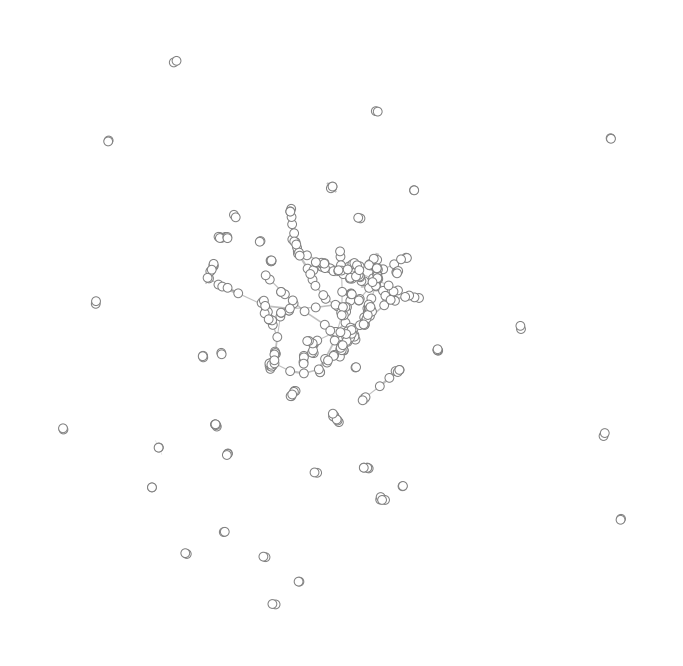

In [10]:
cs.draw_graph(
    H_bicomponents, 
    node_pos=nx.spring_layout(H_bicomponents, seed=0), 
    edge_width_factor=.0001, 
    edge_transparency=.5, 
    figsize='large'
)

## Exercise 2
Construct a simple (undirected) **facebook friends** graph, remove self-loops (for some strange reason some users are friends of themselves), extract the largest connected component, store a `spring_layout()` in a vertex property variable, and draw the graph.

Then identify the network core via $k$-core decomposition. Create a variable $k$ and mark the largest $k$-core using the `highlights()` function (given above, as in the demo).

Hint: You can remove self-loops by calling `G.remove_edges_from(nx.selfloop_edges(G))`.

For later: Can you also color each node by its core number, using the "hot" [colormap](https://matplotlib.org/tutorials/colors/colormaps.html) of matplotlib? That means, nodes should have "hotter" colors the more they belong to the core.
## Solution 2
Graph construction:

In [11]:
G = cs.construct_graph(
    directed=False, 
    multiplex=False, 
    graph_name='facebook_friends', 
    node_list=users, 
    edge_list=facebook_friends, 
    node_label='user'
)

Remove self-loops, extract the largest connected component, and create a layout:

In [12]:
G.remove_edges_from(nx.selfloop_edges(G))
G = G.subgraph(max(nx.connected_components(nx.to_undirected(G)), key=len))
vp_node_pos = nx.spring_layout(G, seed=0)

In [13]:
print(nx.info(G))

Name: facebook_friends
Type: Graph
Number of nodes: 800
Number of edges: 6418
Average degree:  16.0450


Graph drawing:

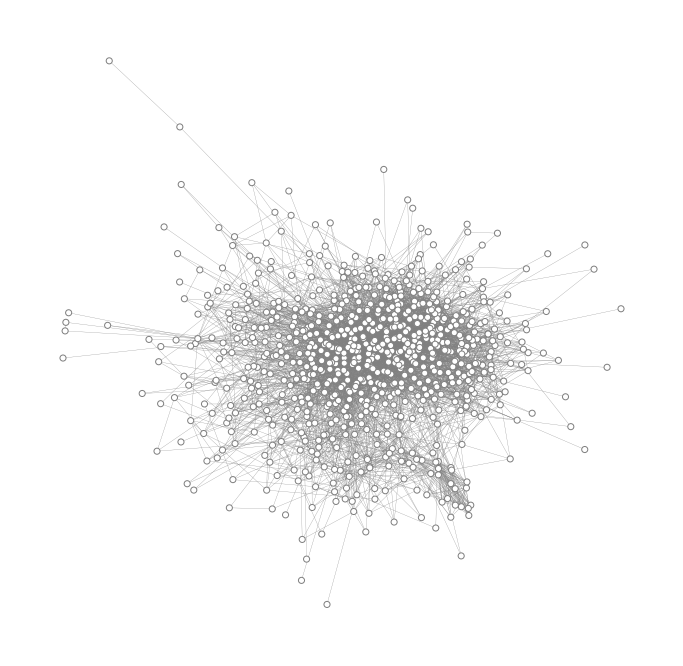

In [14]:
cs.draw_graph(
    G, 
    node_pos=vp_node_pos, 
    edge_width_factor=.25, 
    figsize='large'
)

To do $k$-core decomposition, create a variable $k$ and see the effect of increasing it:

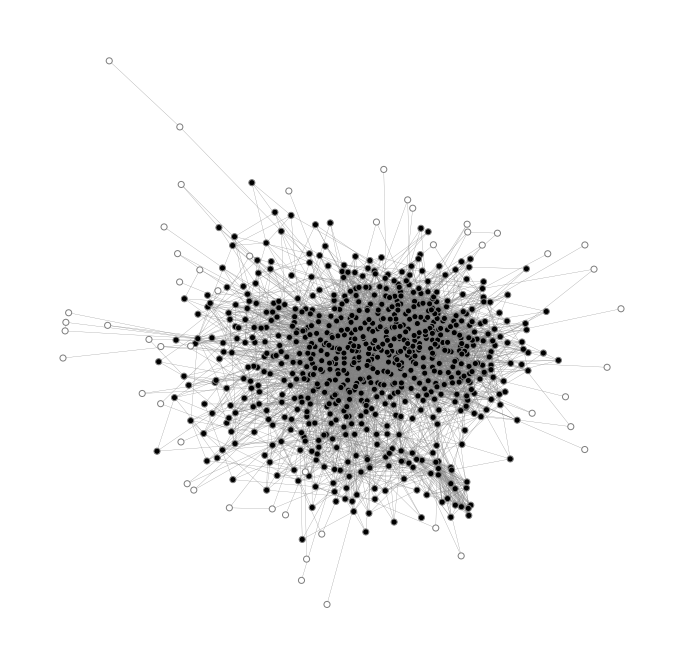

In [15]:
# create a variable k
k = 3

# extract the graph of all k-cores
G_kcore = nx.k_core(G, k=k)

# extract the node set of the largest k-core
sets_nodes_kcores = [c for c in sorted(nx.connected_components(G_kcore), key=len, reverse=True)]
nodes_lkcore = sets_nodes_kcores[0]

# draw the graph
cs.draw_graph(
    G, 
    node_pos=vp_node_pos, 
    node_color=highlights(G, nodes_lkcore), 
    edge_width_factor=.25, 
    figsize='large'
)

To use the colormap approach you need to compute the core numbers of all nodes, map them to colors, and use the created dictionary as a node color attribute:

In [16]:
core_number = nx.core_number(G)
core_number_max = max(core_number.values())
vp_node_color = {node: cm.hot(number/core_number_max) for node, number in core_number.items()}

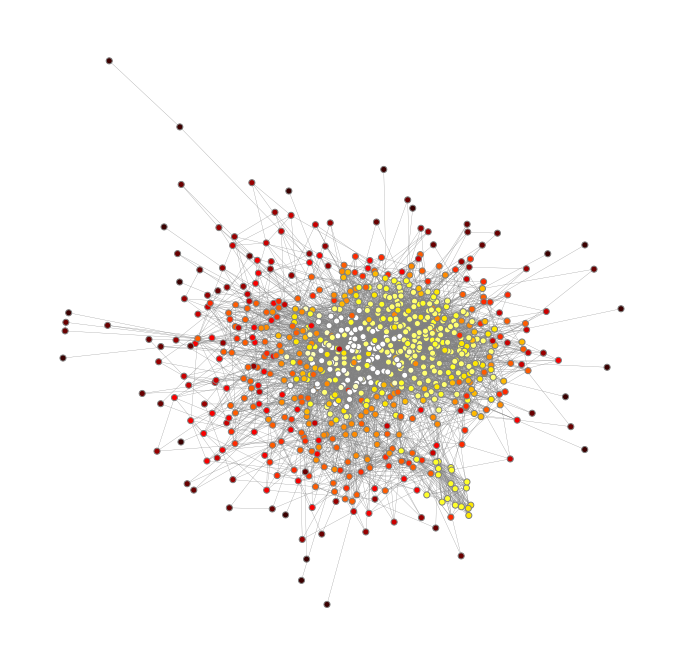

In [17]:
cs.draw_graph(
    G, 
    node_pos=vp_node_pos, 
    node_color=vp_node_color, 
    edge_width_factor=.25, 
    figsize='large'
)